In [ ]:
!pip install --upgrade torchao torch torchvision torchaudio

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.models as models
from tqdm import tqdm
# from google.colab import drive
import random
import numpy as np
import os
import torchao
from copy import deepcopy
import time
from torchao.quantization import (
    quantize_,
    Int8WeightOnlyConfig,
    Int4WeightOnlyConfig,
    Int8DynamicActivationInt4WeightConfig,

)
# from torchao.quantization.qat import QATConfig
from torchao.dtypes import Int4CPULayout
from torch import nn
import torchao
# from torchsummary import summary
# drive.mount('/content/drive')
# model_drive_path = "/content/drive/MyDrive/ATML"

In [16]:
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_WORKERS = 0

In [17]:
def fix_random_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

def get_model_size(model, path="/tmp/temp_model.pt"):
  """
  Save a PyTorch model temporarily and return its size in MB.

  Args:
      model: PyTorch model (nn.Module)
      path: Temporary file path to save the model

  Returns:
      Size of the model in MB (float)
  """
  torch.save(model, path)
  size_mb = os.path.getsize(path) / 1024 / 1024
  return size_mb

Fixed random seed: 42


In [18]:
def train_epoch(model, loader, criterion, optimizer, device):
  model.to(device)
  model.train()
  running_loss, correct, total = 0.0, 0, 0

  for inputs, labels in tqdm(loader):
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    logits = model(inputs)              # forward pass
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(logits.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  avg_loss = running_loss / total
  accuracy = 100. * correct / total
  return avg_loss, accuracy


def evaluate(model, test_loader, device):
  model.eval()
  model.to(device)

  correct = 0
  total = 0

  with torch.no_grad():
    for images, labels in tqdm(test_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  return accuracy

In [19]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

g = torch.Generator()
g.manual_seed(42)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

full_train = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True)
train_subset, val_subset = random_split(full_train, [45000, 5000], generator=g)

train_subset.dataset.transform = train_transform
val_subset.dataset.transform = test_transform
test_dataset.transform = test_transform

print("Training set size:", len(train_subset))
print("Validation set size:", len(val_subset))
print("Test set size:", len(test_dataset))

def get_loader(dataset, shuffle):
    return DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        worker_init_fn=seed_worker,
        generator=g
    )

train_loader = get_loader(train_subset, shuffle=True)
val_loader = get_loader(val_subset, shuffle=False)
test_loader = get_loader(test_dataset, shuffle=False)

Training set size: 45000
Validation set size: 5000
Test set size: 10000


In [20]:
model_base = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
model_base.classifier[6] = torch.nn.Linear(4096, 100)
model_base.classifier[5] = torch.nn.Dropout(p=0.5) # Dropout
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
model = model_base.to(device)

base_lr = 0.04
weight_decay = 5e-4
num_epochs = 6
optim = torch.optim.SGD(
    model_base.parameters(),
    lr=base_lr,
    momentum=0.9,
    weight_decay=weight_decay
)

scheduler = CosineAnnealingLR(optim, T_max=num_epochs, eta_min=1e-5)

criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# for i in range(NUM_EPOCHS):
#   train_loss, train_acc = train_epoch(model, train_loader, criterion, optim, device)
#   test_acc = evaluate(model, test_loader)

#   if (test_acc > best_acc):
#     best_acc = test_acc
#     torch.save(model.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100.pt")

#   torch.save(model.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100_latest.pt")
#   print(f"Epoch: {i+1} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%")

# torch.save(model.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100_5e.pt")

In [21]:
model = deepcopy(model_base)
model.load_state_dict(torch.load("vgg11_cifar100_baseline_5e.pt", map_location=device))

<All keys matched successfully>

In [25]:
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Data Type: {param.dtype}")

start_time = time.time()
base_test_acc = evaluate(model, test_loader, device)
end_time = time.time()

inf_time_base = end_time - start_time

model_size_base = get_model_size(model, "vgg11_base.pt")
print(f"\n FP32: Test Accuracy = {base_test_acc:.2f}, Inference Time = {inf_time_base}, Size = {model_size_base:.2f} MB")

Parameter: features.0.weight, Data Type: torch.float32
Parameter: features.0.bias, Data Type: torch.float32
Parameter: features.3.weight, Data Type: torch.float32
Parameter: features.3.bias, Data Type: torch.float32
Parameter: features.6.weight, Data Type: torch.float32
Parameter: features.6.bias, Data Type: torch.float32
Parameter: features.8.weight, Data Type: torch.float32
Parameter: features.8.bias, Data Type: torch.float32
Parameter: features.11.weight, Data Type: torch.float32
Parameter: features.11.bias, Data Type: torch.float32
Parameter: features.13.weight, Data Type: torch.float32
Parameter: features.13.bias, Data Type: torch.float32
Parameter: features.16.weight, Data Type: torch.float32
Parameter: features.16.bias, Data Type: torch.float32
Parameter: features.18.weight, Data Type: torch.float32
Parameter: features.18.bias, Data Type: torch.float32
Parameter: classifier.0.weight, Data Type: torch.float32
Parameter: classifier.0.bias, Data Type: torch.float32
Parameter: class

100%|██████████| 79/79 [00:53<00:00,  1.47it/s]



 FP32: Test Accuracy = 71.01, Inference Time = 53.71564793586731, Size = 492.78 MB


#Quantisation

#FP16

#PTQ

In [23]:
model_fp16 = deepcopy(model)
model_fp16.half()
model_fp16.to(device)

print("Model parameters and data types after quantization:")
for name, param in model_fp16.named_parameters():
  print(f"Parameter: {name}, Data Type: {param.dtype}")

correct_fp16 = 0
total_fp16 = 0

start_time = time.time()  # start timer

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating FP16"):
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.half()

        outputs = model_fp16(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total_fp16 += labels.size(0)
        correct_fp16 += (predicted == labels).sum().item()

end_time = time.time()
inf_time_fp16 = end_time - start_time

fp16_test_acc = 100 * correct_fp16 / total_fp16
model_size_fp16 = get_model_size(model_fp16, "vgg11_fp16.pt")
print(f"\n FP16: Test Accuracy = {fp16_test_acc:.2f}, Inference Time = {inf_time_fp16}, Size = {model_size_fp16:.2f} MB")

Model parameters and data types after quantization:
Parameter: features.0.weight, Data Type: torch.float16
Parameter: features.0.bias, Data Type: torch.float16
Parameter: features.3.weight, Data Type: torch.float16
Parameter: features.3.bias, Data Type: torch.float16
Parameter: features.6.weight, Data Type: torch.float16
Parameter: features.6.bias, Data Type: torch.float16
Parameter: features.8.weight, Data Type: torch.float16
Parameter: features.8.bias, Data Type: torch.float16
Parameter: features.11.weight, Data Type: torch.float16
Parameter: features.11.bias, Data Type: torch.float16
Parameter: features.13.weight, Data Type: torch.float16
Parameter: features.13.bias, Data Type: torch.float16
Parameter: features.16.weight, Data Type: torch.float16
Parameter: features.16.bias, Data Type: torch.float16
Parameter: features.18.weight, Data Type: torch.float16
Parameter: features.18.bias, Data Type: torch.float16
Parameter: classifier.0.weight, Data Type: torch.float16
Parameter: classifi

Evaluating FP16: 100%|██████████| 79/79 [00:44<00:00,  1.79it/s]



 FP16: Test Accuracy = 67.55, Inference Time = 44.198546171188354, Size = 246.40 MB


#QAT

In [ ]:
model_fp16 = deepcopy(model_base)
model_fp16.half()
model_fp16.to(device)

optim_fp16 = torch.optim.SGD(
    model_fp16.parameters(),
    lr=base_lr,
    momentum=0.9,
    weight_decay=weight_decay
)

scheduler_fp16 = CosineAnnealingLR(optim_fp16, T_max=NUM_EPOCHS, eta_min=1e-5)

criterion_fp16 = torch.nn.CrossEntropyLoss()

class FP16Wrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x.half(), y

fp16_train_loader = get_loader(FP16Wrapper(train_subset), shuffle=True)
fp16_test_loader = get_loader(FP16Wrapper(test_dataset), shuffle=True)
print("Model parameters and data types after quantization:")
for name, param in model_fp16.named_parameters():
  print(f"Parameter: {name}, Data Type: {param.dtype}")


for i in range(2*NUM_EPOCHS):
  train_loss, train_acc = train_epoch(model_fp16, fp16_train_loader, criterion_fp16, optim_fp16, device)
  print(f"Epoch: {i+1} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
  torch.save(model_fp16.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100_latest_fp16.pt")
  if (i >= NUM_EPOCHS - 1):
    fp16_test_acc_qat = evaluate(model_fp16, fp16_test_loader, device)
    print(f"Test Acc: {fp16_test_acc_qat:.2f}")
    if (fp16_test_acc_qat > fp16_test_acc):
      break

Model parameters and data types after quantization:
Parameter: features.0.weight, Data Type: torch.float16
Parameter: features.0.bias, Data Type: torch.float16
Parameter: features.3.weight, Data Type: torch.float16
Parameter: features.3.bias, Data Type: torch.float16
Parameter: features.6.weight, Data Type: torch.float16
Parameter: features.6.bias, Data Type: torch.float16
Parameter: features.8.weight, Data Type: torch.float16
Parameter: features.8.bias, Data Type: torch.float16
Parameter: features.11.weight, Data Type: torch.float16
Parameter: features.11.bias, Data Type: torch.float16
Parameter: features.13.weight, Data Type: torch.float16
Parameter: features.13.bias, Data Type: torch.float16
Parameter: features.16.weight, Data Type: torch.float16
Parameter: features.16.bias, Data Type: torch.float16
Parameter: features.18.weight, Data Type: torch.float16
Parameter: features.18.bias, Data Type: torch.float16
Parameter: classifier.0.weight, Data Type: torch.float16
Parameter: classifi

100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch: 1 -> Train Loss: 2.9538, Train Acc: 27.20%


100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch: 2 -> Train Loss: 1.8831, Train Acc: 48.60%


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 3 -> Train Loss: 1.4562, Train Acc: 59.03%


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 4 -> Train Loss: 1.1460, Train Acc: 67.08%


100%|██████████| 352/352 [02:34<00:00,  2.28it/s]


Epoch: 5 -> Train Loss: 0.9114, Train Acc: 73.24%


100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


Test Acc: 58.98


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 6 -> Train Loss: 0.7332, Train Acc: 78.48%


100%|██████████| 79/79 [00:19<00:00,  4.13it/s]


Test Acc: 58.04


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 7 -> Train Loss: 0.6115, Train Acc: 82.00%


100%|██████████| 79/79 [00:18<00:00,  4.34it/s]


Test Acc: 58.76


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 8 -> Train Loss: 0.5153, Train Acc: 84.74%


100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


Test Acc: 59.12


100%|██████████| 352/352 [02:33<00:00,  2.29it/s]


Epoch: 9 -> Train Loss: 0.4518, Train Acc: 86.72%


100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


Test Acc: 57.51


100%|██████████| 352/352 [02:33<00:00,  2.30it/s]


Epoch: 10 -> Train Loss: 0.3805, Train Acc: 88.93%


 51%|█████     | 40/79 [00:09<00:06,  5.97it/s]

#BF16

In [9]:
model_bf16 = deepcopy(model)

# Quantize the copied model to float16
model_bf16.to(torch.bfloat16)
model_bf16.to(device)

print("Model parameters and data types after quantization:")
for name, param in model_bf16.named_parameters():
  print(f"Parameter: {name}, Data Type: {param.dtype}")

correct_bf16 = 0
total_bf16 = 0

start_time = time.time()

with torch.no_grad():
  for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device=device, dtype=torch.bfloat16), labels.to(device)
    outputs = model_bf16(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total_bf16 += labels.size(0)
    correct_bf16 += (predicted == labels).sum().item()


end_time = time.time()
inf_time_bf16 = end_time - start_time

bf16_test_acc = 100 * correct_bf16 / total_bf16
model_size_bf16 = get_model_size(model_bf16, "vgg11_bf16.pt")
print(f"\n BF16: Test Accuracy = {bf16_test_acc:.2f}, Inference Time = {inf_time_bf16}, Size = {model_size_bf16:.2f} MB")


Model parameters and data types after quantization:
Parameter: features.0.weight, Data Type: torch.bfloat16
Parameter: features.0.bias, Data Type: torch.bfloat16
Parameter: features.3.weight, Data Type: torch.bfloat16
Parameter: features.3.bias, Data Type: torch.bfloat16
Parameter: features.6.weight, Data Type: torch.bfloat16
Parameter: features.6.bias, Data Type: torch.bfloat16
Parameter: features.8.weight, Data Type: torch.bfloat16
Parameter: features.8.bias, Data Type: torch.bfloat16
Parameter: features.11.weight, Data Type: torch.bfloat16
Parameter: features.11.bias, Data Type: torch.bfloat16
Parameter: features.13.weight, Data Type: torch.bfloat16
Parameter: features.13.bias, Data Type: torch.bfloat16
Parameter: features.16.weight, Data Type: torch.bfloat16
Parameter: features.16.bias, Data Type: torch.bfloat16
Parameter: features.18.weight, Data Type: torch.bfloat16
Parameter: features.18.bias, Data Type: torch.bfloat16
Parameter: classifier.0.weight, Data Type: torch.bfloat16
Pa

100%|██████████| 79/79 [01:23<00:00,  1.06s/it]



 BF16: Test Accuracy = 67.45, Inference Time = 83.85210609436035, Size = 246.40 MB


#QAT

In [ ]:
model_bf16 = deepcopy(model)
model_bf16.to(torch.bfloat16)
model_bf16.to(device)

optim_bf16 = torch.optim.SGD(
    model_bf16.parameters(),
    lr=base_lr,
    momentum=0.9,
    weight_decay=weight_decay
)

scheduler_bf16 = CosineAnnealingLR(optim_bf16, T_max=NUM_EPOCHS*2, eta_min=1e-5)

criterion_bf16 = torch.nn.CrossEntropyLoss()

class BF16Wrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return x.to(torch.bfloat16), y

bf16_train_loader = get_loader(BF16Wrapper(train_subset), shuffle=True)
bf16_test_loader = get_loader(BF16Wrapper(test_dataset), shuffle=True)
print("Model parameters and data types after quantization:")
for name, param in model_bf16.named_parameters():
  print(f"Parameter: {name}, Data Type: {param.dtype}")


for i in range(2*NUM_EPOCHS):
  train_loss, train_acc = train_epoch(model_bf16, bf16_train_loader, criterion_bf16, optim_bf16, device)
  torch.save(model_bf16.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100_latest_bf16.pt")
  print(f"Epoch: {i+1} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
  if (i >= NUM_EPOCHS - 1):
    bf16_test_acc_qat = evaluate(model_bf16, bf16_test_loader, device)
    print(f"Test Acc: {bf16_test_acc_qat:.2f}")
    if (bf16_test_acc_qat > 67.45):
      break

#INT8

#PTQ

In [13]:
model_int8 = deepcopy(model)

model_int8.to(device)

quantize_(model_int8, Int8WeightOnlyConfig())

model_int8 = torch.compile(model_int8, mode='max-autotune')

for name, layer in model_int8.named_modules():
    if isinstance(layer, torch.nn.Linear):
        print(f"{name}: {layer.weight.tensor_impl.dtype}")

correct_int8 = 0
total_int8 = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_int8(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total_int8 += labels.size(0)
        correct_int8 += (predicted == labels).sum().item()

end_time = time.time()
inf_time_int8 = end_time - start_time

int8_test_acc = 100 * correct_int8 / total_int8
model_size_int8 = get_model_size(model_int8, "vgg11_int8.pt")
print(f"\n INT8: Test Accuracy = {int8_test_acc:.2f}, Inference Time = {inf_time_int8}, Size = {model_size_int8:.2f} MB")

_orig_mod.classifier.0: torch.int8
_orig_mod.classifier.3: torch.int8
_orig_mod.classifier.6: torch.int8


100%|██████████| 79/79 [00:50<00:00,  1.55it/s]



 INT8: Test Accuracy = 67.20, Inference Time = 50.99435019493103, Size = 149.73 MB


#QAT

In [8]:
model_int_qat = deepcopy(model_base)

model_int_qat.to(device)

base_config = Int8DynamicActivationInt4WeightConfig()
quantize_(model_int_qat, QATConfig(base_config, step="prepare"))

optim_int_qat = torch.optim.SGD(
    model_int_qat.parameters(),
    lr=base_lr,
    momentum=0.9,
    weight_decay=weight_decay
)

scheduler_int_qat = CosineAnnealingLR(optim_int_qat, T_max=NUM_EPOCHS*2, eta_min=1e-5)

criterion_int_qat = torch.nn.CrossEntropyLoss()

for i in range(2*NUM_EPOCHS):
  train_loss, train_acc = train_epoch(model_int_qat, train_loader, criterion_int_qat, optim_int_qat, device)
  print(f"Epoch: {i+1} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
  torch.save(model_int_qat.state_dict(), "/content/drive/MyDrive/ATML/vgg_11_cifar100_latest_int8_qat.pt")
  if (i >= NUM_EPOCHS - 1):
    int_test_acc_qat = evaluate(model_int_qat, test_loader, device)
    print(f"Test Acc: {int_test_acc_qat:.2f}")
    if (int_test_acc_qat > 67.85):
      break

quantize_(model_int_qat, QATConfig(base_config, step="convert"))

model_int_qat = torch.compile(model_int_qat, mode='max-autotune')

for name, layer in model_int_qat.named_modules():
    if isinstance(layer, torch.nn.Linear):
        try:
            # Try LinearActivationQuantizedTensor structure
            dtype = layer.weight.weight.tensor_impl.dtype
            print(f"{name}: {dtype}")
        except AttributeError:
            try:
                # Try AffineQuantizedTensor structure
                dtype = layer.weight.tensor_impl.dtype
                print(f"{name}: {dtype}")
            except AttributeError:
                # Not quantized
                print(f"{name}: {layer.weight.dtype} (not quantized)")

100%|██████████| 352/352 [05:33<00:00,  1.06it/s]


Epoch: 1 -> Train Loss: 2.8029, Train Acc: 29.65%


/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


_orig_mod.classifier.0: torch.float32 (not quantized)
_orig_mod.classifier.3: torch.float32 (not quantized)
_orig_mod.classifier.6: torch.float32 (not quantized)


In [ ]:
correct_int8_qat = 0
total_int8_qat = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_int8_qat(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total_int8_qat += labels.size(0)
        correct_int8_qat += (predicted == labels).sum().item()

end_time = time.time()
inf_time_int8_qat = end_time - start_time

int8_test_acc_qat = 100 * correct_int8_qat / total_int8_qat
model_size_int8_qat = get_model_size(model_int8_qat, "vgg11_int8_qat.pt")
print(f"\n INT8: Test Accuracy = {int8_test_acc:.2f}, Inference Time = {inf_time_int8_qat}, Size = {model_size_int8_qat:.2f} MB")

#INT4

In [ ]:
model_int4 = deepcopy(model)

last_linear = model_int4.classifier[6]
out_features_orig = last_linear.out_features
new_out_features = ((out_features_orig + 15) // 16) * 16

if new_out_features != out_features_orig:
    print(f"Padding last Linear layer from {out_features_orig} -> {new_out_features}")
    new_linear = nn.Linear(last_linear.in_features, new_out_features)
    new_linear.weight.data[:out_features_orig] = last_linear.weight.data
    new_linear.bias.data[:out_features_orig] = last_linear.bias.data
    model_int4.classifier[6] = new_linear

class SliceOutput(nn.Module):
    def __init__(self, model, out_size):
        super().__init__()
        self.model = model
        self.out_size = out_size

    def forward(self, x):
        x = self.model(x)
        return x[:, :self.out_size]

model_int4.to("cpu")

config = Int4WeightOnlyConfig(layout=Int4CPULayout())
quantize_(model_int4, config)

model_int4_sliced = SliceOutput(model_int4, out_features_orig)

correct_int4 = 0
total_int4 = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to("cpu"), labels.to("cpu")
        outputs = model_int4_sliced(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total_int4 += labels.size(0)
        correct_int4 += (predicted == labels).sum().item()

end_time = time.time()
inf_time_int4 = end_time - start_time

int4_test_acc = 100 * correct_int4 / total_int4
model_size_int4 = get_model_size(model_int4, "vgg11_int4.pt")
print(f"\n INT4: Test Accuracy = {int4_test_acc:.2f}, Inference Time = {inf_time_int4}, Size = {model_size_int4:.2f} MB")

In [ ]:
def quantize_int4(tensor):
    """Quantize tensor to int4 (-8..7)"""
    scale = tensor.abs().max() / 7
    q = torch.clamp((tensor / scale).round(), -8, 7).to(torch.int8)
    return q, scale

def pack_int4(q_tensor):
    """Pack 2 int4 values per int8"""
    q_tensor = q_tensor.flatten()
    if len(q_tensor) % 2 != 0:
        q_tensor = torch.cat([q_tensor, torch.tensor([0], dtype=torch.int8)])
    high = (q_tensor[0::2] & 0x0F) << 4
    low = q_tensor[1::2] & 0x0F
    packed = (high | low).clone()
    return packed

def unpack_int4(packed, shape):
    """Unpack int4 to int8 tensor"""
    high = (packed >> 4) & 0x0F
    low = packed & 0x0F
    # convert back to signed
    high = (high + 8) % 16 - 8
    low = (low + 8) % 16 - 8
    q = torch.empty(high.numel()*2, dtype=torch.int8)
    q[0::2] = high
    q[1::2] = low
    return q[:torch.prod(torch.tensor(shape))].view(shape)

class TrueInt4Linear(nn.Module):
    def __init__(self, linear: nn.Linear):
        super().__init__()
        # Quantize weights
        q_weight, self.scale_w = quantize_int4(linear.weight.data)
        self.weight_packed = nn.Parameter(pack_int4(q_weight), requires_grad=False)
        # Bias optional
        if linear.bias is not None:
            q_bias, self.scale_b = quantize_int4(linear.bias.data)
            self.bias_packed = nn.Parameter(pack_int4(q_bias), requires_grad=False)
        else:
            self.bias_packed = None
            self.scale_b = None
        self.in_features = linear.in_features
        self.out_features = linear.out_features

    def forward(self, input):
        # Unpack weights and bias
        device = input.device
        weight_fp32 = unpack_int4(self.weight_packed, (self.out_features, self.in_features)).to(device).float() * self.scale_w
        bias_fp32 = unpack_int4(self.bias_packed, (self.out_features,)).to(device).float() * self.scale_b if self.bias_packed is not None else None
        return nn.functional.linear(input, weight_fp32, bias_fp32)

def replace_linear_true_int4(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Linear):
            setattr(module, name, TrueInt4Linear(child))
        else:
            replace_linear_true_int4(child)

model_int4 = deepcopy(model)
replace_linear_true_int4(model_int4)

model_int4.to(device)

for name, layer in model_int4.named_modules():
    if isinstance(layer, TrueInt4Linear):
        print(f"{name}: packed weight dtype={layer.weight_packed.dtype}, scale_w={layer.scale_w}")

correct_int4 = 0
total_int4 = 0

start_time = time.time()

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_int4(inputs)

        _, predicted = torch.max(outputs.data, 1)

        total_int4 += labels.size(0)
        correct_int4 += (predicted == labels).sum().item()

end_time = time.time()
inf_time_int4 = end_time - start_time

int4_test_acc = 100 * correct_int4 / total_int4
model_size_int4 = get_model_size(model_int4, "vgg11_int4.pt")
print(f"\n INT4: Test Accuracy = {int4_test_acc:.2f}, Inference Time = {inf_time_int4}, Size = {model_size_int4:.2f} MB")

classifier.0: packed weight dtype=torch.int8, scale_w=0.010400212369859219
classifier.3: packed weight dtype=torch.int8, scale_w=0.014500515535473824
classifier.6: packed weight dtype=torch.int8, scale_w=0.02958664856851101


100%|██████████| 79/79 [00:49<00:00,  1.59it/s]



 INT4: Test Accuracy = 67.07, Inference Time = 49.71105599403381, Size = 92.39 MB


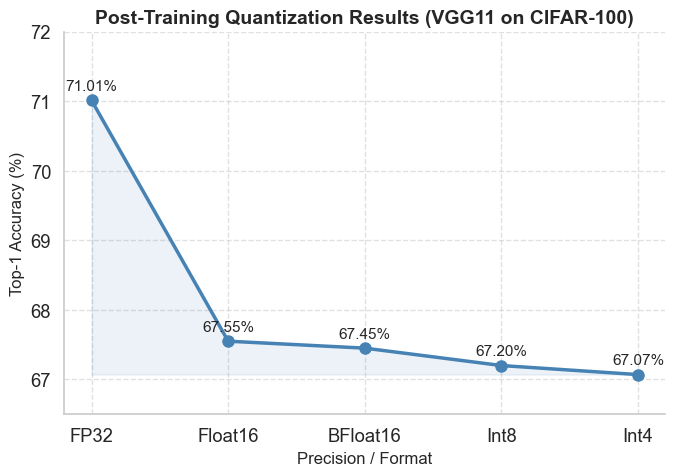

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
methods = ['FP32', 'Float16', 'BFloat16', 'Int8', 'Int4']
accuracy = [71.01, 67.55, 67.45, 67.20, 67.07]

# Style setup
sns.set(style="whitegrid", font_scale=1.2)
colors = sns.color_palette("crest", as_cmap=True)

# Create smooth interpolation (optional, just for smooth curve look)
x = np.arange(len(methods))
plt.figure(figsize=(7, 5))

plt.plot(x, accuracy, marker='o', markersize=8, linewidth=2.5, color='steelblue')
plt.fill_between(x, accuracy, [min(accuracy)]*len(x), alpha=0.1, color='steelblue')

# Annotate points
for xi, acc, label in zip(x, accuracy, methods):
    plt.text(xi, acc + 0.1, f'{acc:.2f}%', ha='center', va='bottom', fontsize=11)

# Labels & style
plt.xticks(x, methods)
plt.title('Post-Training Quantization Results (VGG11 on CIFAR-100)', fontsize=14, weight='bold')
plt.xlabel('Precision / Format', fontsize=12)
plt.ylabel('Top-1 Accuracy (%)', fontsize=12)
plt.ylim(66.5, 72)
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()
